<a href="https://colab.research.google.com/github/M-Waweru/DengueChallenge/blob/master/Obituaries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lifelines
!pip install xgboost
!pip install catboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pp
import datetime as dt
from lifelines import KaplanMeierFitter

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [2]:
# When using Colab, run the code below to load csv

from google.colab import drive
drive.mount('/content/gdrive')

path = "/content/gdrive/My Drive/Colab Notebooks/Obituaries/Obituaries_Dataset.csv"
obituaries_df = pd.read_csv(path)

# When running locally
# obituaries_df = pd.read_csv('Obituaries_Dataset.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
obituaries_df.head()

,Name,Announcement,Death,Burial,Burial_Day,Burial_Week,Gender,Age,Color,Size,Word_Count,No_of_Children,Significant_Children,Significant_Relatives,Fundraising,Death_to_Announce,Death_to_Burial,Announce_to_Burial,No_of_Relatives,County_Burial,County_Death,County_Morgue,Distance_Death,Distance_Morgue,Cause_of_Death,Married,Spouse_Alive,Spouse_gender,Hospital,Morgue,Same_Morgue,Cost_Morgue,Occupation,Repetition,Corporate,Corporate_Name,Residence,Residence_Name,Residence_Category
0,Eng. Paul Chemweno,11/8/2017,11/2/2017,11/17/2017,Friday,Weekday,Male,66.0,Yes,55.18,179,7.0,0.0,0.0,Yes,6,15,9,35,Uasin Gishu,Uasin Gishu,Uasin Gishu,0,0,illness,Yes,Yes,Female,Memorial Hospital Eldoret,MTRH Eldoret,No,NaN,Director,NaN,NaN,NaN,NaN,NaN,NaN
1,Edith Kiende Kiogora,11/8/2017,10/27/2017,11/11/2017,Saturday,Weekend,Female,43.0,Yes,83.60,293,4.0,0.0,7.0,Yes,12,15,3,8,Tharaka Nithi,Nairobi,Tharaka Nithi,224,0,illness,Yes,Yes,Male,Nairobi West Hospital,Chogoria Hospital Mortuary,No,NaN,Teacher,NaN,NaN,NaN,NaN,NaN,NaN
2,Simon Muchiri Ngigii Mbaria,11/8/2017,11/1/2017,11/8/2017,Wednesday,Weekday,Male,35.0,Yes,109.12,206,4.0,0.0,2.0,No,7,7,0,7,Nyandarua,Nyandarua,Nakuru,0,77,illness,Yes,Yes,Female,Charity Hospital Nyahururu,Umash Nakuru,No,NaN,Teacher,NaN,NaN,NaN,NaN,NaN,NaN
3,Mwalimu Erick Namusasi Werunga,11/8/2017,10/24/2017,11/9/2017,Thursday,Weekday,Male,54.0,Yes,83.60,171,4.0,0.0,0.0,No,15,16,1,33,Trans Nzioa,NaN,Trans Nzioa,0,NaN,illness,Yes,No,Female,NaN,Maida Mortuary,NaN,NaN,Teacher,NaN,NaN,NaN,NaN,NaN,NaN
4,Catherine Mueni Sina,11/8/2017,11/2/2017,11/11/2017,Saturday,Weekend,Female,41.0,No,55.18,150,1.0,0.0,NaN,NaN,6,9,3,17,Machakos,Uasin Gishu,NaN,378,NaN,accident,NaN,NaN,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# EDA

In [4]:
obituaries_df.columns

Index(['Name', 'Announcement', 'Death', 'Burial', 'Burial_Day', 'Burial_Week',
       'Gender', 'Age', 'Color', 'Size', 'Word_Count', 'No_of_Children',
       'Significant_Children', 'Significant_Relatives', 'Fundraising',
       'Death_to_Announce', 'Death_to_Burial', 'Announce_to_Burial',
       'No_of_Relatives', 'County_Burial', 'County_Death', 'County_Morgue',
       'Distance_Death', 'Distance_Morgue', 'Cause_of_Death', 'Married',
       'Spouse_Alive', 'Spouse_gender', 'Hospital', 'Morgue', 'Same_Morgue',
       'Cost_Morgue', 'Occupation', 'Repetition', 'Corporate',
       'Corporate_Name', 'Residence', 'Residence_Name', 'Residence_Category'],
      dtype='object')

In [5]:
obituaries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1291 entries, 0 to 1290
Data columns (total 39 columns):
Name                     1291 non-null object
Announcement             1265 non-null object
Death                    893 non-null object
Burial                   1164 non-null object
Burial_Day               1163 non-null object
Burial_Week              1163 non-null object
Gender                   1291 non-null object
Age                      507 non-null float64
Color                    1289 non-null object
Size                     1237 non-null float64
Word_Count               1237 non-null object
No_of_Children           1093 non-null float64
Significant_Children     1092 non-null float64
Significant_Relatives    1083 non-null float64
Fundraising              1142 non-null object
Death_to_Announce        1291 non-null object
Death_to_Burial          1244 non-null object
Announce_to_Burial       1278 non-null object
No_of_Relatives          1061 non-null object
County_Burial   

In [6]:
obituaries_df['Burial_Day'].value_counts()

Saturday     373
Friday       364
Thursday     137
Tuesday      111
Wednesday    101
Monday        50
Sunday        16
saturday      11
Name: Burial_Day, dtype: int64

In [7]:
obituaries_df['Burial_Day'].unique()

array(['Friday', 'Saturday', 'Wednesday', 'Thursday', 'Tuesday', 'Monday',
       nan, 'Sunday', 'saturday'], dtype=object)

In [8]:
pp.ProfileReport(obituaries_df)

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,39
Number of observations,1291
Total Missing (%),38.0%
Total size in memory,393.5 KiB
Average record size in memory,312.1 B
Numeric,5
Categorical,34
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [9]:
obituaries_df.isnull().sum()

Name                        0
Announcement               26
Death                     398
Burial                    127
Burial_Day                128
Burial_Week               128
Gender                      0
Age                       784
Color                       2
Size                       54
Word_Count                 54
No_of_Children            198
Significant_Children      199
Significant_Relatives     208
Fundraising               149
Death_to_Announce           0
Death_to_Burial            47
Announce_to_Burial         13
No_of_Relatives           230
County_Burial             247
County_Death              766
County_Morgue             411
Distance_Death            805
Distance_Morgue           420
Cause_of_Death            493
Married                   243
Spouse_Alive              348
Spouse_gender             356
Hospital                 1024
Morgue                    426
Same_Morgue              1088
Cost_Morgue              1289
Occupation               1040
Repetition

In [10]:
obituaries_df.duplicated().sum()

0

# Data Preparation and Analysis 

In [11]:
obituaries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1291 entries, 0 to 1290
Data columns (total 39 columns):
Name                     1291 non-null object
Announcement             1265 non-null object
Death                    893 non-null object
Burial                   1164 non-null object
Burial_Day               1163 non-null object
Burial_Week              1163 non-null object
Gender                   1291 non-null object
Age                      507 non-null float64
Color                    1289 non-null object
Size                     1237 non-null float64
Word_Count               1237 non-null object
No_of_Children           1093 non-null float64
Significant_Children     1092 non-null float64
Significant_Relatives    1083 non-null float64
Fundraising              1142 non-null object
Death_to_Announce        1291 non-null object
Death_to_Burial          1244 non-null object
Announce_to_Burial       1278 non-null object
No_of_Relatives          1061 non-null object
County_Burial   

In [12]:
obituaries_df.sample(5)

,Name,Announcement,Death,Burial,Burial_Day,Burial_Week,Gender,Age,Color,Size,Word_Count,No_of_Children,Significant_Children,Significant_Relatives,Fundraising,Death_to_Announce,Death_to_Burial,Announce_to_Burial,No_of_Relatives,County_Burial,County_Death,County_Morgue,Distance_Death,Distance_Morgue,Cause_of_Death,Married,Spouse_Alive,Spouse_gender,Hospital,Morgue,Same_Morgue,Cost_Morgue,Occupation,Repetition,Corporate,Corporate_Name,Residence,Residence_Name,Residence_Category
556,Thomas Opiyo Ondigo,5/24/2017,NaN,5/27/2017,Saturday,Weekend,Male,NaN,Yes,56.07,203,4.0,0.0,0.0,No,#VALUE!,5/27/2017,3,22,Migori,NaN,Nairobi,NaN,468,illness,Yes,Yes,Female,NaN,Kenyatta University,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
623,Raphael Ndungi Mathaka,5/31/2017,5/28/2017,3/6/2017,Saturday,Weekend,Male,NaN,Yes,56.07,115,4.0,0.0,0.0,Yes,#VALUE!,6,3,NaN,Makueni,NaN,Nairobi,NaN,132,illness,Yes,Yes,Female,NaN,Chiromo,NaN,NaN,Lecturer,NaN,Yes,Nairobi Technical Training Institute,NaN,NaN,NaN
629,Mary Njeri Kanyanjua,5/31/2017,NaN,NaN,NaN,NaN,Female,NaN,Yes,56.07,130,NaN,NaN,NaN,Yes,#VALUE!,0,7/30/1782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
775,Eunice Katanu,4/7/2017,4/4/2017,4/13/2017,Thursday,weekday,Female,NaN,yes,110.00,194,4.0,0.0,20.0,Yes,3,3,9,6,Machakos,Nairobi,NaN,63,NaN,ilness,yes,Yes,Male,Nairobi hospital,NaN,NaN,NaN,NaN,yes,NaN,National Oil,NaN,NaN,NaN
1186,Mwalimu Simon Nyaga Mathenge,2/23/2017,2/18/2017,2/28/2017,Tuesday,Weekday,Male,NaN,Yes,158.12,225,7.0,1.0,2.0,Yes,5,10,5,17,Nyeri,Nyeri,Nyeri,0,0,illness,Yes,Yes,Female,NaN,Jamii Hospital Mortuary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# Create copy for manipulation purposes
obituaries_copy_df = obituaries_df.copy()

In [14]:
obituaries_copy_df.columns

Index(['Name', 'Announcement', 'Death', 'Burial', 'Burial_Day', 'Burial_Week',
       'Gender', 'Age', 'Color', 'Size', 'Word_Count', 'No_of_Children',
       'Significant_Children', 'Significant_Relatives', 'Fundraising',
       'Death_to_Announce', 'Death_to_Burial', 'Announce_to_Burial',
       'No_of_Relatives', 'County_Burial', 'County_Death', 'County_Morgue',
       'Distance_Death', 'Distance_Morgue', 'Cause_of_Death', 'Married',
       'Spouse_Alive', 'Spouse_gender', 'Hospital', 'Morgue', 'Same_Morgue',
       'Cost_Morgue', 'Occupation', 'Repetition', 'Corporate',
       'Corporate_Name', 'Residence', 'Residence_Name', 'Residence_Category'],
      dtype='object')

In [0]:
# Columns to delete
columns_to_drop = ['Distance_Death', 'Distance_Morgue', 'Same_Morgue', 'Cost_Morgue', 'Occupation', 'Repetition', 'Corporate', 'Corporate_Name', 'Residence', 'Residence_Name', 'Residence_Category']

def deleteCols(df, cols):
  df.drop(columns=cols, inplace=True)
  return df

# Columns for dates to parse
columns_to_parse = ['Announcement', 'Death', 'Burial']

def parseTheDates(df, cols):
  for col in cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')
  return df

# Columns to change from object to float
columns_to_float = ['Word_Count', 'Death_to_Announce', 'Death_to_Burial', 'Announce_to_Burial', 'No_of_Relatives']   

def changeDataTypes(df, cols):
  for col in cols:
    df.loc[df[col] == '#VALUE!', col] = np.nan 
    df[col] = pd.to_numeric(df[col].str.replace(',', ''), errors='coerce')
    print(col)
  return df

# changeDataTypes(obituaries_copy_df, ['Distance_Morgue']).sample(10)

# Sorting out issues in various columns
def fixColValues(df):
  df['Cause_of_Death'] = df['Cause_of_Death'].replace('Illness', 'illness')
  df['Cause_of_Death'] = df['Cause_of_Death'].replace('ilness', 'illness')
  df['Cause_of_Death'] = df['Cause_of_Death'].replace('Accident', 'accident')
  df['Burial_Day'] = df['Burial_Day'].replace('saturday', 'Saturday')
  df['Color'] = df['Color'].replace('yes', 'Yes')
  df['Color'] = df['Color'].replace('no', 'No')
  df['Married'] = df['Married'].replace('yes', 'Yes')
  df['Married'] = df['Married'].replace('no', 'No')
  return df

# Recalculate days between announcement, death and burial
def recalculateCols(df):
  df['Death_to_Announce'] = (df['Announcement'] - df['Death']).dt.days

  df['Death_to_Burial'] = (df['Burial'] - df['Death']).dt.days

  df['Announce_to_Burial'] = (df['Burial'] - df['Announcement']).dt.days

  return df
 

In [16]:
# jhkjh
prepared_df = (obituaries_copy_df.pipe(deleteCols, cols=columns_to_drop)
                                .pipe(parseTheDates, cols=columns_to_parse)
                                .pipe(changeDataTypes, cols=columns_to_float)
                                .pipe(fixColValues)
                                .pipe(recalculateCols))
prepared_df.head()

Word_Count
Death_to_Announce
Death_to_Burial
Announce_to_Burial
No_of_Relatives


,Name,Announcement,Death,Burial,Burial_Day,Burial_Week,Gender,Age,Color,Size,Word_Count,No_of_Children,Significant_Children,Significant_Relatives,Fundraising,Death_to_Announce,Death_to_Burial,Announce_to_Burial,No_of_Relatives,County_Burial,County_Death,County_Morgue,Cause_of_Death,Married,Spouse_Alive,Spouse_gender,Hospital,Morgue
0,Eng. Paul Chemweno,2017-11-08,2017-11-02,2017-11-17,Friday,Weekday,Male,66.0,Yes,55.18,179.0,7.0,0.0,0.0,Yes,6.0,15.0,9.0,35.0,Uasin Gishu,Uasin Gishu,Uasin Gishu,illness,Yes,Yes,Female,Memorial Hospital Eldoret,MTRH Eldoret
1,Edith Kiende Kiogora,2017-11-08,2017-10-27,2017-11-11,Saturday,Weekend,Female,43.0,Yes,83.60,293.0,4.0,0.0,7.0,Yes,12.0,15.0,3.0,8.0,Tharaka Nithi,Nairobi,Tharaka Nithi,illness,Yes,Yes,Male,Nairobi West Hospital,Chogoria Hospital Mortuary
2,Simon Muchiri Ngigii Mbaria,2017-11-08,2017-11-01,2017-11-08,Wednesday,Weekday,Male,35.0,Yes,109.12,206.0,4.0,0.0,2.0,No,7.0,7.0,0.0,7.0,Nyandarua,Nyandarua,Nakuru,illness,Yes,Yes,Female,Charity Hospital Nyahururu,Umash Nakuru
3,Mwalimu Erick Namusasi Werunga,2017-11-08,2017-10-24,2017-11-09,Thursday,Weekday,Male,54.0,Yes,83.60,171.0,4.0,0.0,0.0,No,15.0,16.0,1.0,33.0,Trans Nzioa,NaN,Trans Nzioa,illness,Yes,No,Female,NaN,Maida Mortuary
4,Catherine Mueni Sina,2017-11-08,2017-11-02,2017-11-11,Saturday,Weekend,Female,41.0,No,55.18,150.0,1.0,0.0,NaN,NaN,6.0,9.0,3.0,17.0,Machakos,Uasin Gishu,NaN,accident,NaN,NaN,Male,NaN,NaN


In [17]:
prepared_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1291 entries, 0 to 1290
Data columns (total 28 columns):
Name                     1291 non-null object
Announcement             1263 non-null datetime64[ns]
Death                    887 non-null datetime64[ns]
Burial                   1164 non-null datetime64[ns]
Burial_Day               1163 non-null object
Burial_Week              1163 non-null object
Gender                   1291 non-null object
Age                      507 non-null float64
Color                    1289 non-null object
Size                     1237 non-null float64
Word_Count               1237 non-null float64
No_of_Children           1093 non-null float64
Significant_Children     1092 non-null float64
Significant_Relatives    1083 non-null float64
Fundraising              1142 non-null object
Death_to_Announce        864 non-null float64
Death_to_Burial          835 non-null float64
Announce_to_Burial       1137 non-null float64
No_of_Relatives          1060 non-nu

# Data Visualization

In [18]:
prepared_df.sample(10)

,Name,Announcement,Death,Burial,Burial_Day,Burial_Week,Gender,Age,Color,Size,Word_Count,No_of_Children,Significant_Children,Significant_Relatives,Fundraising,Death_to_Announce,Death_to_Burial,Announce_to_Burial,No_of_Relatives,County_Burial,County_Death,County_Morgue,Cause_of_Death,Married,Spouse_Alive,Spouse_gender,Hospital,Morgue
548,Francis Howard Okello Anunda,2017-05-24,2017-05-14,2017-05-27,Saturday,Weekend,Male,78.0,No,56.07,204.0,4.0,0.0,0.0,No,10.0,13.0,3.0,18.0,Kakamega,Uasin Gishu,Uasin Gishu,illness,Yes,Yes,Female,Moi Teaching And Refferal Hospital,Moi Teaching And Refferal Hospital
963,Alloys Mayalo,2017-05-30,2017-05-23,2017-05-31,Wednesday,Weekday,Male,NaN,Yes,56.32,172.0,3.0,0.0,12.0,Yes,7.0,8.0,1.0,1.0,Nairobi,Kajiado,NaN,cancer,No,NaN,NaN,NaN,NaN
286,Mama Ezina Malina Lugadiru,2017-05-23,2017-05-16,2017-05-27,Saturday,Weekend,Female,82.0,Yes,56.07,194.0,10.0,5.0,3.0,No,7.0,11.0,4.0,22.0,Vihiga,NaN,Vihiga,illness,Yes,Yes,Male,NaN,Jumuia Hospital Morgue
1120,John P Njenga,2017-02-21,2017-02-18,NaT,NaN,NaN,Male,62.0,Yes,83.60,138.0,2.0,0.0,0.0,Yes,3.0,NaN,NaN,13.0,NaN,NaN,NaN,NaN,Yes,Yes,Female,NaN,NaN
814,Joe Ephraim,2017-05-18,NaT,2017-05-20,Saturday,weekend,Male,76.0,Yes,66.88,270.0,8.0,0.0,16.0,No,NaN,NaN,2.0,2.0,Kirinyaga,NaN,Kirinyaga,NaN,Yes,No,Female,NaN,Jamii funeral home
558,Fredrick Musembi Muia,2017-05-24,2017-05-14,2017-05-27,Saturday,Weekend,Male,34.0,Yes,85.44,230.0,1.0,0.0,2.0,No,10.0,13.0,3.0,30.0,Machakos,NaN,Machakos,accident,Yes,Yes,Female,NaN,Montezuma Nairobi
786,Wilfred Chemobo,2017-04-07,2017-03-26,2017-08-04,Saturday,Weekend,Male,77.0,Yes,68.64,445.0,6.0,2.0,36.0,No,12.0,131.0,119.0,1.0,Uasin Gishu,Nairobi,Nairobi,road accident,Yes,Yes,Female,Kenyatta National Hosp,KNH mortuary
766,Joseph Wandimi,2017-04-08,2017-05-04,2017-11-04,Thursday,Weekday,Male,72.0,Yes,56.32,207.0,6.0,0.0,25.0,No,-26.0,184.0,210.0,3.0,Nyeri,NaN,Nairobi,illness,Yes,Yes,Female,NaN,Kenyatta University
464,Eunice Wambua Kiama,2017-03-15,2017-10-03,2017-03-18,Saturday,Weekend,Female,NaN,Yes,56.07,203.0,9.0,2.0,3.0,No,-202.0,-199.0,3.0,4.0,Nyeri,NaN,Nyeri,illness,Yes,No,Male,NaN,P.C.E.A Tumutumu Hospital
73,Elder Simon Mwaniki Kamutu,2016-11-27,2016-12-22,2017-01-09,Monday,Weekday,Male,NaN,Yes,68.53,157.0,6.0,2.0,0.0,No,-25.0,18.0,43.0,NaN,Nyandarua,Nairobi,Nairobi,illness,Yes,Yes,Female,Nairobi Womens Hospital,Nairobi Women's Hospital Funeral Home


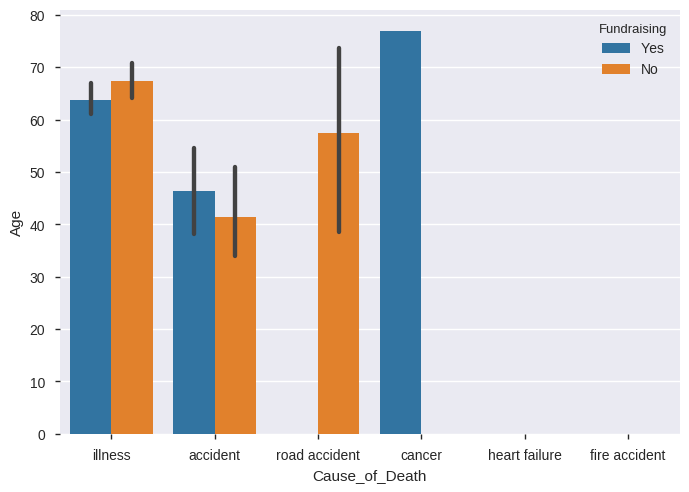

In [19]:
sns.barplot(x=prepared_df['Cause_of_Death'], y=prepared_df['Age'], hue=prepared_df['Fundraising'])

In [20]:
prepared_df['Cause_of_Death'].value_counts()

illness          738
accident          46
road accident      8
cancer             4
heart failure      1
fire accident      1
Name: Cause_of_Death, dtype: int64

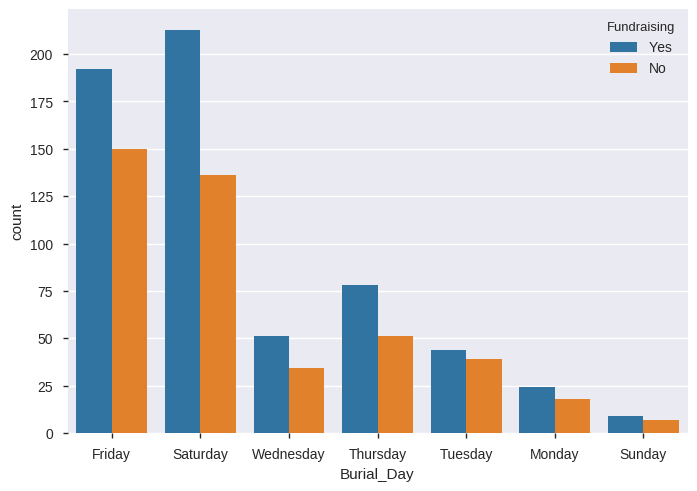

In [21]:
sns.countplot(x=prepared_df['Burial_Day'], hue=prepared_df['Fundraising'])

In [22]:
prepared_df['Color'].unique()

array(['Yes', 'No', nan], dtype=object)

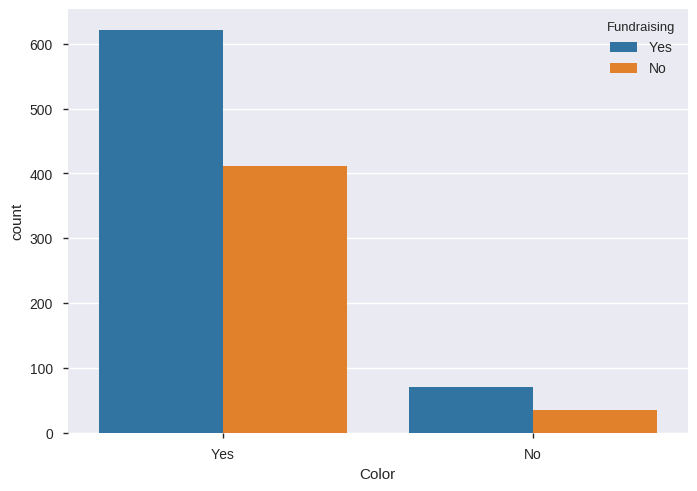

In [23]:
sns.countplot(x=prepared_df['Color'], hue=prepared_df['Fundraising'])

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


Text(0.5, 1.0, 'Frequency of Ages')

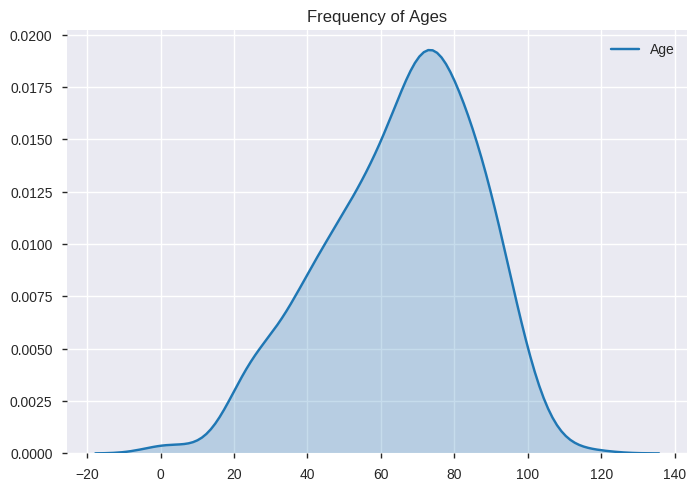

In [24]:
sns.kdeplot(prepared_df['Age'], shade=True)
plt.title('Frequency of Ages')

In [25]:
pp.ProfileReport(prepared_df)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,28
Number of observations,1291
Total Missing (%),22.3%
Total size in memory,282.5 KiB
Average record size in memory,224.1 B
Numeric,10
Categorical,15
Boolean,0
Date,3
Text (Unique),0
Rejected,0


# Kaplan-Meier Survival Analysis

In [26]:
kmf_df = prepared_df.copy()

kmf_df['Observed_Announce'] = np.where(kmf_df['Announcement'] != np.nan, True, False)

kmf_df = kmf_df.dropna(axis=0, subset=['Age'])

kmf_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 507 entries, 0 to 1290
Data columns (total 29 columns):
Name                     507 non-null object
Announcement             493 non-null datetime64[ns]
Death                    413 non-null datetime64[ns]
Burial                   484 non-null datetime64[ns]
Burial_Day               484 non-null object
Burial_Week              484 non-null object
Gender                   507 non-null object
Age                      507 non-null float64
Color                    506 non-null object
Size                     486 non-null float64
Word_Count               487 non-null float64
No_of_Children           457 non-null float64
Significant_Children     456 non-null float64
Significant_Relatives    452 non-null float64
Fundraising              455 non-null object
Death_to_Announce        400 non-null float64
Death_to_Burial          393 non-null float64
Announce_to_Burial       471 non-null float64
No_of_Relatives          443 non-null float64
Count

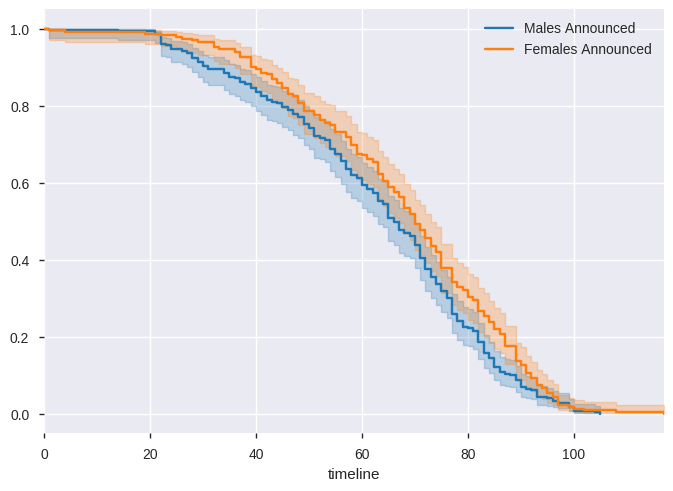

In [27]:
# KMF for Gender

kmfgenders = KaplanMeierFitter()

genderkmf_df = kmf_df.copy()

male = genderkmf_df[genderkmf_df['Gender'] == 'Male']
female = genderkmf_df[genderkmf_df['Gender'] == 'Female']

# fit model for male
kmfgenders.fit(male['Age'], male['Observed_Announce'], label='Males Announced')
maleplot = kmfgenders.plot()

# fit model for female
kmfgenders.fit(female['Age'], female['Observed_Announce'], label='Females Announced')
femaleplot = kmfgenders.plot()

In [28]:
genderkmf_df.isnull().sum()

Name                       0
Announcement              14
Death                     94
Burial                    23
Burial_Day                23
Burial_Week               23
Gender                     0
Age                        0
Color                      1
Size                      21
Word_Count                20
No_of_Children            50
Significant_Children      51
Significant_Relatives     55
Fundraising               52
Death_to_Announce        107
Death_to_Burial          114
Announce_to_Burial        36
No_of_Relatives           64
County_Burial             70
County_Death             290
County_Morgue            136
Cause_of_Death           176
Married                   63
Spouse_Alive             106
Spouse_gender            110
Hospital                 399
Morgue                   144
Observed_Announce          0
dtype: int64

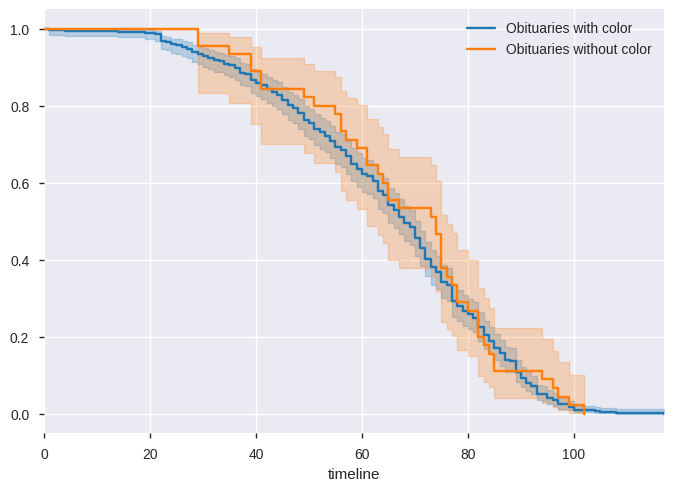

In [29]:
# KMF for Color

kmf = KaplanMeierFitter()

colorkmf_df = kmf_df.copy()

yes_color = colorkmf_df[colorkmf_df['Color'] == 'Yes']
no_color = colorkmf_df[colorkmf_df['Color'] == 'No']

# fit model for male
kmf.fit(yes_color['Age'], yes_color['Observed_Announce'], label='Obituaries with color')
kmf.plot()

# fit model for female
kmf.fit(no_color['Age'], no_color['Observed_Announce'], label='Obituaries without color')
kmf.plot()

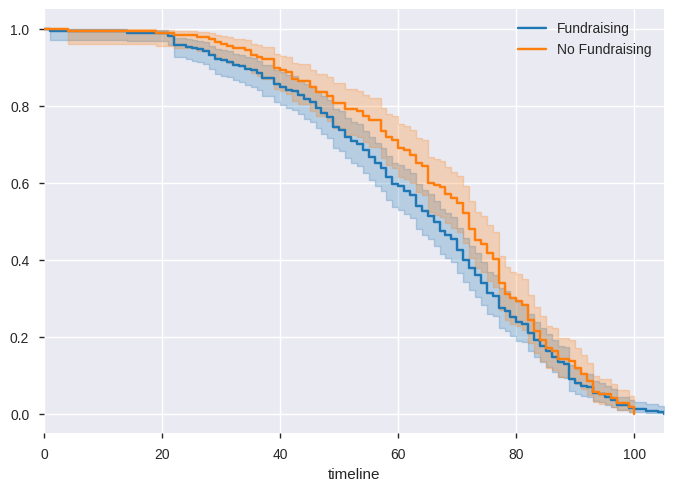

In [30]:
# KMF for Fundraising

kmf = KaplanMeierFitter()

fundkmf_df = kmf_df.copy()

yes_fund = fundkmf_df[fundkmf_df['Fundraising'] == 'Yes']
no_fund = fundkmf_df[fundkmf_df['Fundraising'] == 'No']

# fit model for yes fundraising
kmf.fit(yes_fund['Age'], yes_fund['Observed_Announce'], label='Fundraising')
kmf.plot()

# fit model for no fundraising
kmf.fit(no_fund['Age'], no_fund['Observed_Announce'], label='No Fundraising')
kmf.plot()

In [31]:
kmf_df['Spouse_Alive'].value_counts()

Yes     264
No      134
None      3
Name: Spouse_Alive, dtype: int64

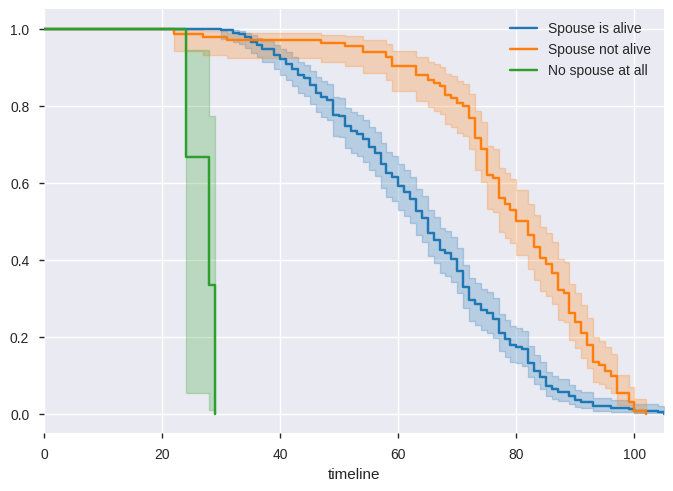

In [32]:
# KMF for Spouse Alive

kmf = KaplanMeierFitter()

spousealivekmf_df = kmf_df.copy()

yes_spouse = spousealivekmf_df[spousealivekmf_df['Spouse_Alive'] == 'Yes']
no_spouse = spousealivekmf_df[spousealivekmf_df['Spouse_Alive'] == 'No']
none_spouse = spousealivekmf_df[spousealivekmf_df['Spouse_Alive'] == 'None']

# fit model for male
kmf.fit(yes_spouse['Age'], yes_spouse['Observed_Announce'], label='Spouse is alive')
kmf.plot()

# fit model for female
kmf.fit(no_spouse['Age'], no_spouse['Observed_Announce'], label='Spouse not alive')
kmf.plot()

kmf.fit(none_spouse['Age'], none_spouse['Observed_Announce'], label='No spouse at all')
kmf.plot()

In [33]:
kmf_df['Spouse_gender'].value_counts()

Female    221
Male      173
None        3
Name: Spouse_gender, dtype: int64

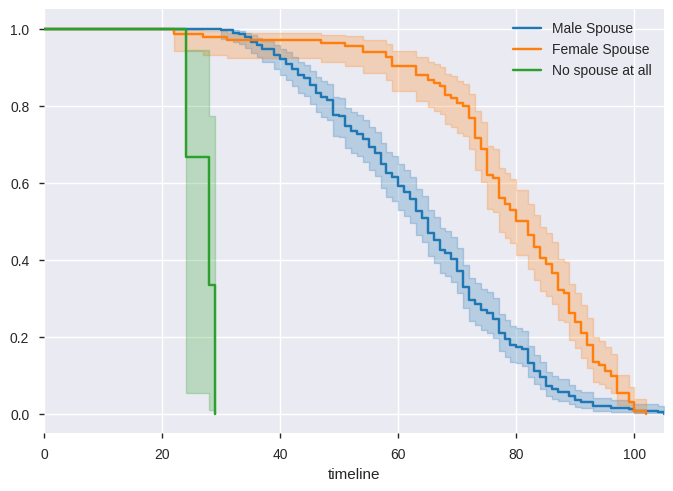

In [34]:
# KMF for Spouse Gender

kmf = KaplanMeierFitter()

spousegenderkmf_df = kmf_df.copy()

male_spouse = spousegenderkmf_df[spousegenderkmf_df['Spouse_Alive'] == 'Yes']
female_spouse = spousegenderkmf_df[spousegenderkmf_df['Spouse_Alive'] == 'No']
none_spouse = spousegenderkmf_df[spousegenderkmf_df['Spouse_Alive'] == 'None']

# fit model for male
kmf.fit(male_spouse['Age'], male_spouse['Observed_Announce'], label='Male Spouse')
kmf.plot()

# fit model for female
kmf.fit(female_spouse['Age'], female_spouse['Observed_Announce'], label='Female Spouse')
kmf.plot()

kmf.fit(none_spouse['Age'], none_spouse['Observed_Announce'], label='No spouse at all')
kmf.plot()

# Dealing with Null Values

In [35]:
prepared_df.isnull().sum()

Name                        0
Announcement               28
Death                     404
Burial                    127
Burial_Day                128
Burial_Week               128
Gender                      0
Age                       784
Color                       2
Size                       54
Word_Count                 54
No_of_Children            198
Significant_Children      199
Significant_Relatives     208
Fundraising               149
Death_to_Announce         427
Death_to_Burial           456
Announce_to_Burial        154
No_of_Relatives           231
County_Burial             247
County_Death              766
County_Morgue             411
Cause_of_Death            493
Married                   243
Spouse_Alive              348
Spouse_gender             356
Hospital                 1024
Morgue                    426
dtype: int64

In [0]:
transformed_df = prepared_df.copy()

transformed_df['Announcement'].fillna(method='ffill', inplace=True)

In [0]:
# Discarding all rows with null values in Fundraising, Size and Word_count columns
columns_for_nulls = ['Fundraising', 'Size', 'Color', 'Age', 'No_of_Children',
       'Significant_Children', 'Significant_Relatives', 'No_of_Relatives']

def removeNullCols(df, cols):
  for col in cols:
    df = df[df[col].notnull()]
  return df

columns_for_unknowns = ['County_Burial', 'County_Death', 'County_Morgue','Cause_of_Death', 'Married',
       'Spouse_Alive', 'Spouse_gender', 'Hospital', 'Morgue', 'Burial_Day', 'Burial_Week']

def replaceUnknown(df, cols):
  for col in cols:
    df[col].fillna('Unknown', inplace=True)
  return df

columns_to_fill = ['Death', 'Burial']

def fillDates(df, cols):
  for col in cols:
    df[col].fillna(df['Announcement'], inplace=True)
  return df

In [38]:
transformed_df.columns

Index(['Name', 'Announcement', 'Death', 'Burial', 'Burial_Day', 'Burial_Week',
       'Gender', 'Age', 'Color', 'Size', 'Word_Count', 'No_of_Children',
       'Significant_Children', 'Significant_Relatives', 'Fundraising',
       'Death_to_Announce', 'Death_to_Burial', 'Announce_to_Burial',
       'No_of_Relatives', 'County_Burial', 'County_Death', 'County_Morgue',
       'Cause_of_Death', 'Married', 'Spouse_Alive', 'Spouse_gender',
       'Hospital', 'Morgue'],
      dtype='object')

In [39]:
# Pipe for dealing with null values

transformed_df = (transformed_df.pipe(replaceUnknown, cols=columns_for_unknowns)
                                .pipe(removeNullCols, cols=columns_for_nulls)
                                .pipe(fillDates, cols=columns_to_fill)
                                .pipe(recalculateCols))

transformed_df.shape

(437, 28)

In [40]:
transformed_df.isnull().sum()

Name                     0
Announcement             0
Death                    0
Burial                   0
Burial_Day               0
Burial_Week              0
Gender                   0
Age                      0
Color                    0
Size                     0
Word_Count               0
No_of_Children           0
Significant_Children     0
Significant_Relatives    0
Fundraising              0
Death_to_Announce        0
Death_to_Burial          0
Announce_to_Burial       0
No_of_Relatives          0
County_Burial            0
County_Death             0
County_Morgue            0
Cause_of_Death           0
Married                  0
Spouse_Alive             0
Spouse_gender            0
Hospital                 0
Morgue                   0
dtype: int64

# Feature Engineering

In [41]:
prepared_df.head()

,Name,Announcement,Death,Burial,Burial_Day,Burial_Week,Gender,Age,Color,Size,Word_Count,No_of_Children,Significant_Children,Significant_Relatives,Fundraising,Death_to_Announce,Death_to_Burial,Announce_to_Burial,No_of_Relatives,County_Burial,County_Death,County_Morgue,Cause_of_Death,Married,Spouse_Alive,Spouse_gender,Hospital,Morgue
0,Eng. Paul Chemweno,2017-11-08,2017-11-02,2017-11-17,Friday,Weekday,Male,66.0,Yes,55.18,179.0,7.0,0.0,0.0,Yes,6.0,15.0,9.0,35.0,Uasin Gishu,Uasin Gishu,Uasin Gishu,illness,Yes,Yes,Female,Memorial Hospital Eldoret,MTRH Eldoret
1,Edith Kiende Kiogora,2017-11-08,2017-10-27,2017-11-11,Saturday,Weekend,Female,43.0,Yes,83.60,293.0,4.0,0.0,7.0,Yes,12.0,15.0,3.0,8.0,Tharaka Nithi,Nairobi,Tharaka Nithi,illness,Yes,Yes,Male,Nairobi West Hospital,Chogoria Hospital Mortuary
2,Simon Muchiri Ngigii Mbaria,2017-11-08,2017-11-01,2017-11-08,Wednesday,Weekday,Male,35.0,Yes,109.12,206.0,4.0,0.0,2.0,No,7.0,7.0,0.0,7.0,Nyandarua,Nyandarua,Nakuru,illness,Yes,Yes,Female,Charity Hospital Nyahururu,Umash Nakuru
3,Mwalimu Erick Namusasi Werunga,2017-11-08,2017-10-24,2017-11-09,Thursday,Weekday,Male,54.0,Yes,83.60,171.0,4.0,0.0,0.0,No,15.0,16.0,1.0,33.0,Trans Nzioa,NaN,Trans Nzioa,illness,Yes,No,Female,NaN,Maida Mortuary
4,Catherine Mueni Sina,2017-11-08,2017-11-02,2017-11-11,Saturday,Weekend,Female,41.0,No,55.18,150.0,1.0,0.0,NaN,NaN,6.0,9.0,3.0,17.0,Machakos,Uasin Gishu,NaN,accident,NaN,NaN,Male,NaN,NaN


In [42]:
def extract_date(df, column):
  df[column+'_day'] = df[column].apply(lambda x: x.day)
  df[column+'_month'] = df[column].apply(lambda x: x.month)
  df[column+'_year'] = df[column].apply(lambda x: x.year)

extract_date(prepared_df, 'Announcement')
extract_date(prepared_df, 'Death')
extract_date(prepared_df, 'Burial')
prepared_df.sample(5)

,Name,Announcement,Death,Burial,Burial_Day,Burial_Week,Gender,Age,Color,Size,Word_Count,No_of_Children,Significant_Children,Significant_Relatives,Fundraising,Death_to_Announce,Death_to_Burial,Announce_to_Burial,No_of_Relatives,County_Burial,County_Death,County_Morgue,Cause_of_Death,Married,Spouse_Alive,Spouse_gender,Hospital,Morgue,Announcement_day,Announcement_month,Announcement_year,Death_day,Death_month,Death_year,Burial_day,Burial_month,Burial_year
1092,Samuel Williamson Guantai,2017-02-21,2017-02-18,2017-02-24,Friday,Weekday,Male,NaN,Yes,83.60,200.0,5.0,5.0,0.0,Yes,3.0,6.0,3.0,12.0,Meru,Meru,meru,illness,Yes,Yes,Female,NaN,Meru Funeral Home,21.0,2.0,2017.0,18.0,2.0,2017.0,24.0,2.0,2017.0
1245,Dorothy Rahab Otieno,2017-03-30,2017-03-22,2017-04-06,Thursday,Weekday,Female,NaN,Yes,84.48,141.0,2.0,0.0,0.0,Yes,8.0,15.0,7.0,7.0,Nairobi,Nairobi,Nairobi,illness,No,NaN,NaN,Coptic Hospital,Coptic Hospital Mortuary,30.0,3.0,2017.0,22.0,3.0,2017.0,6.0,4.0,2017.0
1195,Mike Munyi Mbogo,2017-02-23,NaT,2017-02-28,Tuesday,Weekday,Male,NaN,Yes,56.66,198.0,2.0,0.0,3.0,Yes,NaN,NaN,5.0,24.0,Embu,Embu,Embu,illness,Yes,Yes,Female,NaN,Gakwegori Funeral Home,23.0,2.0,2017.0,NaN,NaN,NaN,28.0,2.0,2017.0
1025,Nelson Omanya Okumu,2017-02-15,2017-02-09,2017-02-17,Friday,Weekday,Male,NaN,Yes,88.48,120.0,7.0,3.0,0.0,Yes,6.0,8.0,2.0,9.0,Siaya,Siaya,Siaya,illness,Yes,Yes,Female,NaN,Kirindo Funeral Home,15.0,2.0,2017.0,9.0,2.0,2017.0,17.0,2.0,2017.0
1206,Jared Ongeri,2017-02-23,2017-02-17,2017-03-03,Friday,Weekday,Male,37.0,Yes,216.00,84.0,0.0,0.0,5.0,Yes,6.0,14.0,8.0,5.0,Bungoma,Bungoma,Bungoma,illness,No,NaN,NaN,NaN,Cherangany nursing Home,23.0,2.0,2017.0,17.0,2.0,2017.0,3.0,3.0,2017.0


# Feature Selection

In [43]:
prepared_df.shape

(1291, 37)

In [44]:
prepared_df.columns

Index(['Name', 'Announcement', 'Death', 'Burial', 'Burial_Day', 'Burial_Week',
       'Gender', 'Age', 'Color', 'Size', 'Word_Count', 'No_of_Children',
       'Significant_Children', 'Significant_Relatives', 'Fundraising',
       'Death_to_Announce', 'Death_to_Burial', 'Announce_to_Burial',
       'No_of_Relatives', 'County_Burial', 'County_Death', 'County_Morgue',
       'Cause_of_Death', 'Married', 'Spouse_Alive', 'Spouse_gender',
       'Hospital', 'Morgue', 'Announcement_day', 'Announcement_month',
       'Announcement_year', 'Death_day', 'Death_month', 'Death_year',
       'Burial_day', 'Burial_month', 'Burial_year'],
      dtype='object')

In [45]:
y = transformed_df['Fundraising']

x = transformed_df.drop(['Name', 'Announcement', 'Death', 'Burial', 'Fundraising'], axis=1)

x.head()

,Burial_Day,Burial_Week,Gender,Age,Color,Size,Word_Count,No_of_Children,Significant_Children,Significant_Relatives,Death_to_Announce,Death_to_Burial,Announce_to_Burial,No_of_Relatives,County_Burial,County_Death,County_Morgue,Cause_of_Death,Married,Spouse_Alive,Spouse_gender,Hospital,Morgue
0,Friday,Weekday,Male,66.0,Yes,55.18,179.0,7.0,0.0,0.0,6,15,9,35.0,Uasin Gishu,Uasin Gishu,Uasin Gishu,illness,Yes,Yes,Female,Memorial Hospital Eldoret,MTRH Eldoret
1,Saturday,Weekend,Female,43.0,Yes,83.60,293.0,4.0,0.0,7.0,12,15,3,8.0,Tharaka Nithi,Nairobi,Tharaka Nithi,illness,Yes,Yes,Male,Nairobi West Hospital,Chogoria Hospital Mortuary
2,Wednesday,Weekday,Male,35.0,Yes,109.12,206.0,4.0,0.0,2.0,7,7,0,7.0,Nyandarua,Nyandarua,Nakuru,illness,Yes,Yes,Female,Charity Hospital Nyahururu,Umash Nakuru
3,Thursday,Weekday,Male,54.0,Yes,83.60,171.0,4.0,0.0,0.0,15,16,1,33.0,Trans Nzioa,Unknown,Trans Nzioa,illness,Yes,No,Female,Unknown,Maida Mortuary
5,Thursday,Weekday,Female,92.0,Yes,55.18,174.0,4.0,1.0,7.0,6,7,1,19.0,Meru,Unknown,Meru,Unknown,Yes,No,Male,Unknown,Meru Funeral Home


In [46]:
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.2, 
                                                    random_state=7)
x_train.shape, x_test.shape

((349, 23), (88, 23))

# Modeling

In [55]:
# XGBoost

xgb_classifier = xgb.XGBClassifier()

xgb_classifier.fit(x_train, y_train)

xgb_pred = xgb_classifier.predict(x_test)

accuracy_score(y_test, xgb_pred)

ValueError: ignored

In [48]:
x_train.head()

,Burial_Day,Burial_Week,Gender,Age,Color,Size,Word_Count,No_of_Children,Significant_Children,Significant_Relatives,Death_to_Announce,Death_to_Burial,Announce_to_Burial,No_of_Relatives,County_Burial,County_Death,County_Morgue,Cause_of_Death,Married,Spouse_Alive,Spouse_gender,Hospital,Morgue
1265,Friday,Weekday,Female,75.0,Yes,67.76,240.0,14.0,0.0,0.0,0,2,2,16.0,Nyeri,Nyeri,Nyeri,illness,Yes,No,Male,Unknown,Mukurweini Hospital Mortuary
884,Friday,Weekday,Male,84.0,Yes,56.32,292.0,15.0,0.0,21.0,0,3,3,3.0,Nyamira,Unknown,Nakuru,Unknown,Yes,Yes,Female,Unknown,War memorial hosp mortuary Nakuru
295,Friday,Weekday,Male,65.0,Yes,145.07,286.0,5.0,0.0,4.0,10,13,3,23.0,Meru,Unknown,Nairobi,illness,Yes,Yes,Female,Unknown,Nairobi Womens Hospital
711,Saturday,weekend,Female,59.0,Yes,109.12,370.0,4.0,0.0,7.0,3,122,119,1.0,Nyeri,Nairobi,Nairobi,illness,Yes,Yes,Male,Kenyatta national hosp,KNH mortuary
304,Saturday,Weekend,Female,58.0,Yes,128.16,264.0,4.0,0.0,0.0,3,7,4,23.0,Uasin Gishu,Unknown,Uasin Gishu,illness,Yes,No,Male,Unknown,Moi Teaching And Referral Mortuary


In [49]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349 entries, 1265 to 645
Data columns (total 23 columns):
Burial_Day               349 non-null object
Burial_Week              349 non-null object
Gender                   349 non-null object
Age                      349 non-null float64
Color                    349 non-null object
Size                     349 non-null float64
Word_Count               349 non-null float64
No_of_Children           349 non-null float64
Significant_Children     349 non-null float64
Significant_Relatives    349 non-null float64
Death_to_Announce        349 non-null int64
Death_to_Burial          349 non-null int64
Announce_to_Burial       349 non-null int64
No_of_Relatives          349 non-null float64
County_Burial            349 non-null object
County_Death             349 non-null object
County_Morgue            349 non-null object
Cause_of_Death           349 non-null object
Married                  349 non-null object
Spouse_Alive             349 non-

In [51]:
x_train['Gender'].unique()

array(['Female', 'Male'], dtype=object)

In [54]:
# CATBoost

cb_classifier = CatBoostClassifier(iterations=30, depth=3, learning_rate=0.1)

cb_classifier.fit(x_train, y_train, cat_features=['Gender', 'Burial_Day', 'Burial_Week', 'Color', 'County_Burial', 'County_Death', 'County_Morgue', 'Cause_of_Death', 'Married', 'Spouse_Alive', 'Spouse_gender',
       'Hospital', 'Morgue'])

y_pred_cb = cb_classifier.predict(x_test)

print(classification_report(y_test, y_pred_cb))

0:	learn: 0.6820618	total: 1.91ms	remaining: 55.5ms
1:	learn: 0.6679095	total: 4.02ms	remaining: 56.2ms
2:	learn: 0.6515852	total: 5.66ms	remaining: 50.9ms
3:	learn: 0.6420165	total: 7.06ms	remaining: 45.9ms
4:	learn: 0.6255007	total: 8.3ms	remaining: 41.5ms
5:	learn: 0.6197924	total: 9.59ms	remaining: 38.3ms
6:	learn: 0.6135473	total: 10.9ms	remaining: 35.7ms
7:	learn: 0.6053573	total: 12.1ms	remaining: 33.4ms
8:	learn: 0.5972754	total: 13.2ms	remaining: 30.9ms
9:	learn: 0.5925676	total: 14.3ms	remaining: 28.6ms
10:	learn: 0.5864640	total: 15.3ms	remaining: 26.5ms
11:	learn: 0.5825028	total: 16.4ms	remaining: 24.6ms
12:	learn: 0.5704065	total: 17.4ms	remaining: 22.8ms
13:	learn: 0.5668933	total: 18.5ms	remaining: 21.1ms
14:	learn: 0.5592816	total: 19.5ms	remaining: 19.5ms
15:	learn: 0.5556798	total: 20.5ms	remaining: 17.9ms
16:	learn: 0.5500099	total: 21.6ms	remaining: 16.5ms
17:	learn: 0.5434937	total: 22.6ms	remaining: 15.1ms
18:	learn: 0.5372030	total: 23.5ms	remaining: 13.6ms
19:	

In [56]:
confusion_matrix(y_test, y_pred_cb)

array([[14, 20],
       [15, 39]])